# Unraveling the MRG myelinated axon model

## Introduction

The McIntyre-Richardson-Grill (MRG) model [1] is pretty much the gold standard in the field to describe mathematically the electrical behavior of myelinated axons under physiological conditions and upon artificial electrical stimulation. The original model implemented in *NEURON* is available on ModelDB and has been extensively re-used by other researchers.

Yet, the model internal implementation has not been extensively characterized, and visual inspection reveals a significant degree of "mess", which hinders the model's adoption.

Hence, we aim here at conducting an exhaustive clean-up of the model implementation, and showcasing a framework to analyze the model's responses to various types of artificial stimuli.

### Imports

In [1]:
from IPython.display import display, Markdown
import numpy as np
import logging
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from PySONIC.core import PulsedProtocol
from PySONIC.neurons import getPointNeuron
from PySONIC.utils import logger, bounds, si_format

from ExSONIC.core import MRGFiber, IntracellularCurrent, ExtracellularCurrent
from ExSONIC.batches import StrengthDurationBatch, StrengthDistanceBatch, ConductionVelocityBatch
from ExSONIC.plt import SectionCompTimeSeries, strengthDurationCurve, strengthDistanceCurve, plotFieldDistribution, plotFiberXCoords, plotMRGLookups, plotCVvsDiameter

logger.setLevel(logging.INFO)

### Parameters

In [2]:
nnodes = 21
fiberD = 10e-6  # um
fiberD_range = (5e-6, 20e-6)  # um
rho_ext = (300., 1200.)  # Ohm.cm
pp = PulsedProtocol(100e-6, 3e-3)  # s
dense_diameters = np.linspace(*fiberD_range, 10)  # m
sparse_diameters = np.array([5., 10., 20.]) * 1e-6  # m
SD_durations = np.logspace(-5, -1, 10)  # s
SD_offset = 3e-3  # s
SD_outkey = 'Ithr (A)'
SD_root = 'strengthDurationData'
CV_root='conductionVelocityData'
paired_colors = list(plt.get_cmap('Paired').colors)
triad_colors = list(plt.get_cmap('tab20b').colors)
del triad_colors[::4]

### Model variants

In [3]:
fiber_classes = {
    'normal': MRGFiber.__originalVbased__,
    'sonic': MRGFiber}
fiber_variants = {k: v(fiberD, nnodes) for k, v in fiber_classes.items()}

### Functions

In [4]:
def plotSimIClamp(fiber, pp, I=None, ylim=None, title=None):
    if I is not None:
        polarity = 'cathode' if I < 0 else 'anode'
    else:
        polarity = 'anode'    
    source = IntracellularCurrent(fiber.central_ID, I=I, mode=polarity)
    data, meta = fiber.simulate(source, pp)
    fig = SectionCompTimeSeries([(data, meta)], 'Vm', fiber.nodeIDs).render()
    if ylim is not None:
        fig.axes[0].set_ylim(ylim)
    if title is not None:
        fig.axes[0].set_title(title)
    return fig

def plotSimExtSource(fiber, source, pp, ylim=None, title=None):
    data, meta = fiber.simulate(source, pp)
    fig = SectionCompTimeSeries([(data, meta)], 'Vm', fiber.nodeIDs).render()
    if ylim is not None:
        fig.axes[0].set_ylim(ylim)
    if title is not None:
        fig.axes[0].set_title(title)
    return fig

## Fiber model

### Nodal transmembrane dynamics

The MRG model paper describes a nodal membrane dynamics comprised of 3 active ionic currents (fast Na+, persistent Na+ and slow K+) and a passive leakage current.

However, the reference MOD file describing the corresponding dynamics is quite obscure and contains many unnecessary functions. 

Hence, a first effort was made to produce a cleaned-up version of this file, with clear definitions of the voltage-dependent ion channels rate constant functions:

In [5]:
with open('../ExSONIC/nmodl/MRGnode_clean.mod', encoding="utf8") as f:
    display(Markdown(f'```text\n{f.read()}```'))

```text
TITLE MRG model nodal membrane dynamics

COMMENT
Equations governing the nodal membrane dynamics of a motor axon fiber, based on the MRG model.

This mod file is based on the original AXNODE.mod file found on ModelDB
(https://senselab.med.yale.edu/ModelDB/showmodel.cshtml?model=3810),
but the equations have been cleaned up to facilitate readibility.

Reference: McIntyre CC, Richardson AG, and Grill WM. Modeling the excitability
of mammalian nerve fibers: influence of afterpotentials on the recovery cycle.
Journal of Neurophysiology 87:995-1006, 2002.

@Author: Theo Lemaire, EPFL
@Date: 2020-03-25
@Email: theo.lemaire@epfl.ch
ENDCOMMENT

INDEPENDENT {t FROM 0 TO 1 WITH 1 (ms)}

NEURON {
	SUFFIX MRGnode
	NONSPECIFIC_CURRENT inaf
	NONSPECIFIC_CURRENT inap
	NONSPECIFIC_CURRENT iks
	NONSPECIFIC_CURRENT il
	RANGE gnafbar, gnapbar, gksbar, gl, ena, ek, el
	RANGE Qm : section specific
	RANGE stimon     : common to all sections (but set as RANGE to be accessible from caller)
}


UNITS {
	(mA) = (milliamp)
	(mV) = (millivolt)
}

PARAMETER {
	stimon       : Stimulation state
	celsius			(degC)
	v				(mV)
	q10_mp
	q10_h
	q10_s
	gnafbar	= 3.0	(mho/cm2)
	gnapbar = 0.01	(mho/cm2)
	gksbar = 0.08	(mho/cm2)
	gl = 0.007		(mho/cm2)
	ena = 50.0		(mV)
	ek = -90.0		(mV)
	el = -90.0		(mV)
	mhshift = 3.	(mV)
	vtraub = -80.	(mV)
}

STATE {
	m h p s
}

ASSIGNED {
	Qm (nC/cm2)
	inaf	(mA/cm2)
	inap	(mA/cm2)
	iks		(mA/cm2)
	il      (mA/cm2)
}

BREAKPOINT {
	SOLVE states METHOD cnexp
	Qm = v
	inaf = gnafbar * m * m * m * h * (v - ena)
	inap = gnapbar * p * p * p * (v - ena)
	iks = gksbar * s * (v - ek)
	il = gl * (v - el)
}

DERIVATIVE states {
	m' = alpham(v) * (1 - m) - betam(v) * m
	h' = alphah(v) * (1 - h) - betah(v) * h
	p' = alphap(v) * (1 - p) - betap(v) * p
	s' = alphas(v) * (1 - s) - betas(v) * s
}

INITIAL {
	q10_mp = 2.2^((celsius - 20) / 10)
	q10_h = 2.9^((celsius - 20) / 10)
	q10_s = 3.0^((celsius - 36)/ 10)
	m = alpham(v) / (alpham(v) + betam(v))
	h = alphah(v) / (alphah(v) + betah(v))
	p = alphap(v) / (alphap(v) + betap(v))
	s = alphas(v) / (alphas(v) + betas(v))
}

FUNCTION vtrap(x, y) {
    vtrap = x / (exp(x / y) - 1)
}

FUNCTION alpham (v(mV)) {
	alpham = q10_mp * 1.86 * vtrap(-(v + mhshift + 18.4), 10.3)
}

FUNCTION betam (v(mV)) {
	betam = q10_mp * 0.086 * vtrap(v + mhshift + 22.7, 9.16)
}

FUNCTION alphah (v(mV)) {
	alphah = q10_h * 0.062 * vtrap(v + mhshift + 111.0, 11.0)
}

FUNCTION betah (v(mV)) {
	betah = q10_h * 2.3 / (1 + exp(-(v + mhshift + 28.8) / 13.4))
}

FUNCTION alphap (v(mV)) {
	alphap = q10_mp * 0.01 * vtrap(-(v + 27.), 10.2)
}

FUNCTION betap (v(mV)) {
	betap = q10_mp * 0.00025 * vtrap(v + 34., 10.)
}

FUNCTION alphas (v(mV)) {
	alphas = q10_s * 0.3 / (1 + exp(-(v - vtraub - 27.) / 5.))
}

FUNCTION betas (v(mV)) {
	betas = q10_s * 0.03 / (1 + exp(-(v - vtraub + 10.) / 1.))
}
```

This MOD file file has been checked against the original one, and was found to produce identical model behavior under various stimulation conditions. Note that two extra variables, `Qm` and `stimon`, have been added here for compliance within our testing framework, but they can be removed from the MOD file.

### Morphological parameters

The MRG model is based on morphological parameters that have only been defined for a specific set of fiber diameters. We wish to interpolate these parameters over a continuous range of fiber diameters following the physiological range observed in human myelinated fibers (i.e. 5 - 20 um).

In this prospect, we'll test here different interpolation methods, including piecewise interpolators (linear, quadratic and cubic) and polynomial fits (1st, 2nd and 3rd degree).

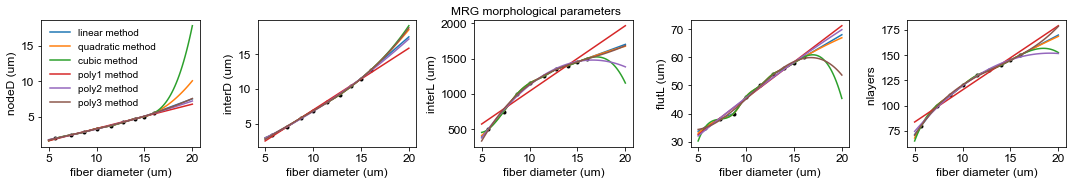

In [6]:
fig = plotMRGLookups(fiberD_range=fiberD_range)

As we can see, quadratic and cubic predictors (both piecewise interpolators and polynomial fits) capture the fine variation trends within the lookup range of diameters and yield vrey smooth profiles, but they all produce unrealistic predictions outside of the lookup range for at least one of the morphological parameters. Moreover, the linear polynomial fit does not capture the fine variation trends within the diameter lookup range.

On the other hand, the **piecewise linear interpolator does produce rather sharp slope changes in the profile** (although without discontinuity in the values), but it **correctly captures internal trends and provides realistic extrapolation outside of the lookup range**. Hence, we select it as the **optimal interpolation method**. 

### Model variants

Let's look at the geometrical / biophysical details per section type for a 10 um diameter fiber using both construction variants: the standard V-based approach, and the sonic Q-casted approach with a custom-defined connection network.

#### Standard connection scheme

In [7]:
fiber_variants['normal'].getSectionsDetails()

,nsec,nseg,diam (um),L (um),cm (uF/cm2),Ra (Ohm.cm),rx (MOhms),gx (S/cm2),cx (uF/cm2)
node,21,1,3.3,1.000000,2.0,70.0,337396.911461,1.000000e+09,0.000000
MYSA,40,1,3.3,3.000000,2.0,70.0,337396.911461,1.262626e-05,0.001263
FLUT,40,1,6.9,46.000000,2.0,70.0,80683.994905,6.038647e-06,0.000604
STIN,120,1,6.9,175.166667,2.0,70.0,80683.994905,6.038647e-06,0.000604


#### Custom connection scheme

In [8]:
fiber_variants['sonic'].getSectionsDetails()

,nsec,nseg,diam (um),L (um),cm (uF/cm2),Ra (Ohm.cm),rx (MOhms),gx (S/cm2),cx (uF/cm2)
node,21,1,3.3,1.000000,1.0,70.0,337396.911461,5.000000e+08,0.000000
MYSA,40,1,3.3,3.000000,1.0,70.0,337396.911461,1.262626e-05,0.001263
FLUT,40,1,6.9,46.000000,1.0,70.0,80683.994905,6.038647e-06,0.000604
STIN,120,1,6.9,175.166667,1.0,70.0,80683.994905,6.038647e-06,0.000604


As we can see, the custom connection scheme sets all membrane capacitance to 1, since the system is charge-casted.

### Morphology 

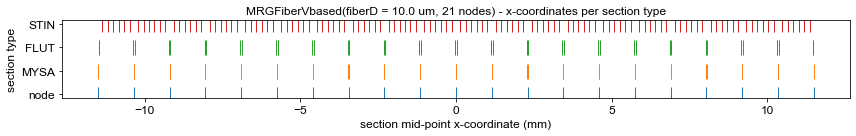

In [9]:
fig = plotFiberXCoords(fiber_variants['normal'])

As we can see, the longitudinal distribution of sections appear to be correct.

## Responses to intracellular stimulation

### Comparison: typical supra-threshold response

As a first check, we verify that both model construction variants produce identical responses to intracellular stimulation:

MRGFiberVbased(fiberD = 10.0 um, 21 nodes)


 18/06/2020 14:57:23: MRGFiberVbased(fiberD = 10.0 um, 21 nodes): simulation @ IntracellularCurrent(sec_id=node10, I=10.0pA, mode=anode), tstim = 100us, toffset = 3ms
 18/06/2020 14:57:24: MRGFiberVbased(fiberD = 10.0 um, 21 nodes): simulation @ IntracellularCurrent(sec_id=node10, I=20.0pA, mode=anode), tstim = 100us, toffset = 3ms
 18/06/2020 14:57:25: MRGFiberVbased(fiberD = 10.0 um, 21 nodes): simulation @ IntracellularCurrent(sec_id=node10, I=40.0pA, mode=anode), tstim = 100us, toffset = 3ms
 18/06/2020 14:57:25: MRGFiberVbased(fiberD = 10.0 um, 21 nodes): simulation @ IntracellularCurrent(sec_id=node10, I=80.0pA, mode=anode), tstim = 100us, toffset = 3ms
 18/06/2020 14:57:26: MRGFiberVbased(fiberD = 10.0 um, 21 nodes): simulation @ IntracellularCurrent(sec_id=node10, I=160.0pA, mode=anode), tstim = 100us, toffset = 3ms
 18/06/2020 14:57:26: MRGFiberVbased(fiberD = 10.0 um, 21 nodes): simulation @ IntracellularCurrent(sec_id=node10, I=320.0pA, mode=anode), tstim = 100us, toffset = 

MRGFiber(fiberD = 10.0 um, 21 nodes)


 18/06/2020 14:57:35: MRGFiber(fiberD = 10.0 um, 21 nodes): simulation @ IntracellularCurrent(sec_id=node10, I=10.0pA, mode=anode), tstim = 100us, toffset = 3ms
 18/06/2020 14:57:37: MRGFiber(fiberD = 10.0 um, 21 nodes): simulation @ IntracellularCurrent(sec_id=node10, I=20.0pA, mode=anode), tstim = 100us, toffset = 3ms
 18/06/2020 14:57:39: MRGFiber(fiberD = 10.0 um, 21 nodes): simulation @ IntracellularCurrent(sec_id=node10, I=40.0pA, mode=anode), tstim = 100us, toffset = 3ms
 18/06/2020 14:57:40: MRGFiber(fiberD = 10.0 um, 21 nodes): simulation @ IntracellularCurrent(sec_id=node10, I=80.0pA, mode=anode), tstim = 100us, toffset = 3ms
 18/06/2020 14:57:42: MRGFiber(fiberD = 10.0 um, 21 nodes): simulation @ IntracellularCurrent(sec_id=node10, I=160.0pA, mode=anode), tstim = 100us, toffset = 3ms
 18/06/2020 14:57:44: MRGFiber(fiberD = 10.0 um, 21 nodes): simulation @ IntracellularCurrent(sec_id=node10, I=320.0pA, mode=anode), tstim = 100us, toffset = 3ms
 18/06/2020 14:57:46: MRGFiber(f

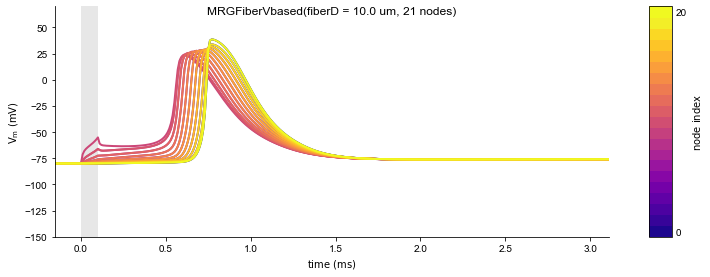

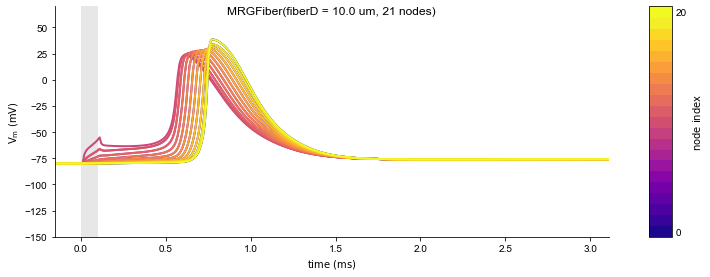

In [10]:
for cl, fiber in fiber_variants.items():
    print(fiber)
    fig = plotSimIClamp(fiber, pp, title=fiber)

We obtain identical threshold excitation currents and identical distributed transmembrane voltage profiles, which confirms that both construction variants produce equivalent electrical responses.

### Comparison: DAPs & AHPs following depolarizing pulses (McIntyre 2002, fig 2A)

 18/06/2020 14:58:08: MRGFiberVbased(fiberD = 10.0 um, 21 nodes): simulation @ IntracellularCurrent(sec_id=node10, I=1.2nA, mode=anode), tstim = 100us, toffset = 100ms
 18/06/2020 14:58:14: MRGFiber(fiberD = 10.0 um, 21 nodes): simulation @ IntracellularCurrent(sec_id=node10, I=1.2nA, mode=anode), tstim = 100us, toffset = 100ms


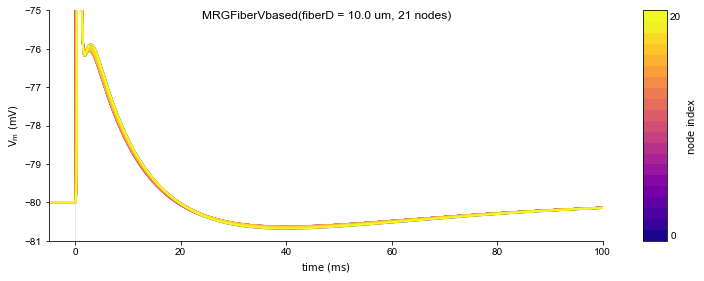

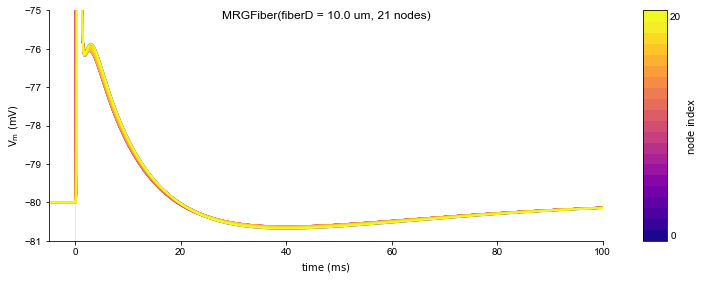

In [11]:
for cl, fiber in fiber_variants.items():
    fig = plotSimIClamp(fiber, PulsedProtocol(100e-6, 100e-3), I=1.2e-9, ylim=(-81, -75), title=fiber)

Looking more in details at the voltage temporal dynamics in the 100 ms following a spike, we the presence of a depolarizing afterpotential (DAP) followed by an after hyperpolarizing potential (AHP), as observed in the reference paper (fig 2A).

### Comparison: AHPs following hyperpolarizing pulses (McIntyre 2002, fig 2B)

 18/06/2020 14:58:20: MRGFiberVbased(fiberD = 10.0 um, 21 nodes): simulation @ IntracellularCurrent(sec_id=node10, I=-500.0pA, mode=cathode), tstim = 2ms, toffset = 20ms
 18/06/2020 14:58:22: MRGFiber(fiberD = 10.0 um, 21 nodes): simulation @ IntracellularCurrent(sec_id=node10, I=-500.0pA, mode=cathode), tstim = 2ms, toffset = 20ms


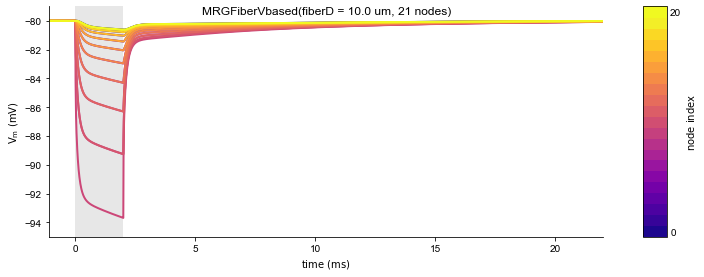

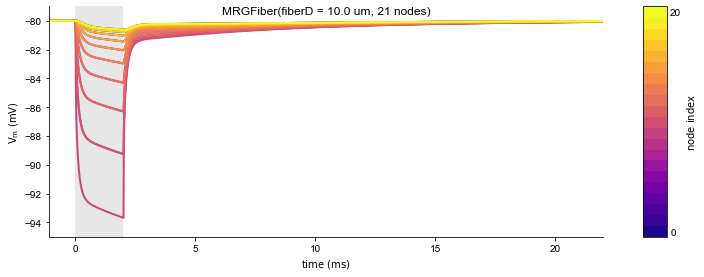

In [12]:
for cl, fiber in fiber_variants.items():
    fig = plotSimIClamp(fiber, PulsedProtocol(2e-3, 20e-3), I=-0.5e-9, ylim=(-95, -79), title=fiber)

Moreover, the model produced an AHP following a hyperpolarizing pulse, similarly as the reference paper (fig 2B).

### Comparison: impulse-dependent AHP amplitude (McIntyre 2002, fig 6)

 18/06/2020 14:58:25: MRGFiberVbased(fiberD = 10.0 um, 21 nodes): simulation @ IntracellularCurrent(sec_id=node10, I=1.5nA, mode=anode), tstim = 5ms, toffset = 195ms, PRF = 200.00Hz, DC = 2.0%
 18/06/2020 14:58:35: MRGFiber(fiberD = 10.0 um, 21 nodes): simulation @ IntracellularCurrent(sec_id=node10, I=1.5nA, mode=anode), tstim = 5ms, toffset = 195ms, PRF = 200.00Hz, DC = 2.0%
 18/06/2020 14:58:46: MRGFiberVbased(fiberD = 10.0 um, 21 nodes): simulation @ IntracellularCurrent(sec_id=node10, I=1.5nA, mode=anode), tstim = 15ms, toffset = 185ms, PRF = 200.00Hz, DC = 2.0%
 18/06/2020 14:58:56: MRGFiber(fiberD = 10.0 um, 21 nodes): simulation @ IntracellularCurrent(sec_id=node10, I=1.5nA, mode=anode), tstim = 15ms, toffset = 185ms, PRF = 200.00Hz, DC = 2.0%
 18/06/2020 14:59:07: MRGFiberVbased(fiberD = 10.0 um, 21 nodes): simulation @ IntracellularCurrent(sec_id=node10, I=1.5nA, mode=anode), tstim = 35ms, toffset = 165ms, PRF = 200.00Hz, DC = 2.0%
 18/06/2020 14:59:17: MRGFiber(fiberD = 10.0

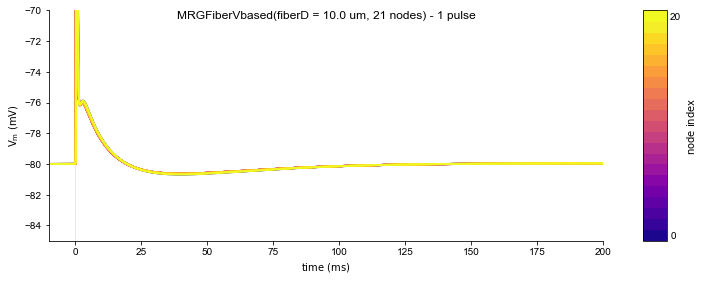

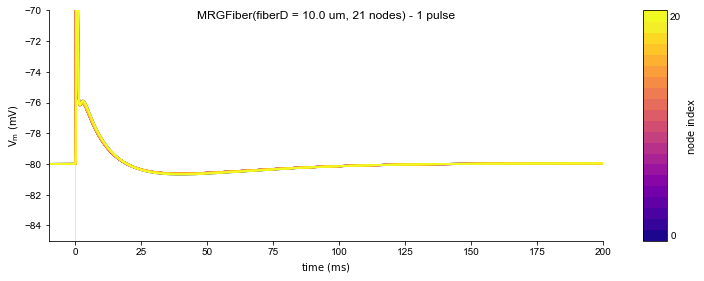

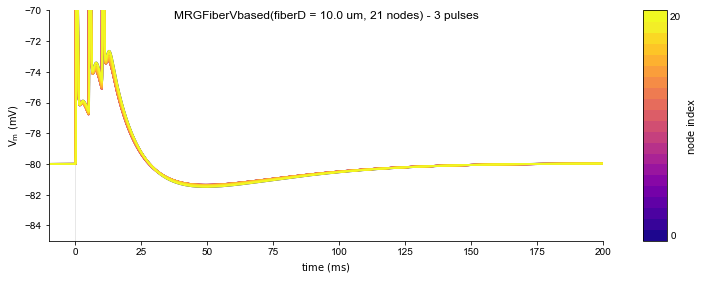

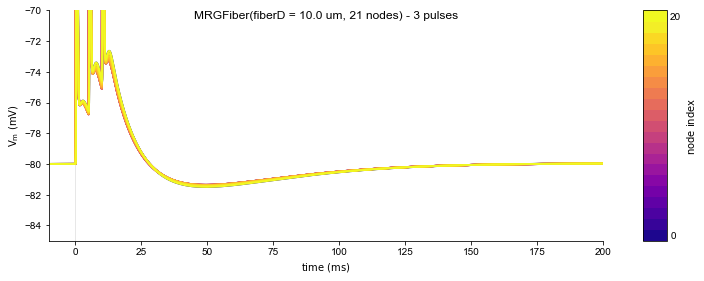

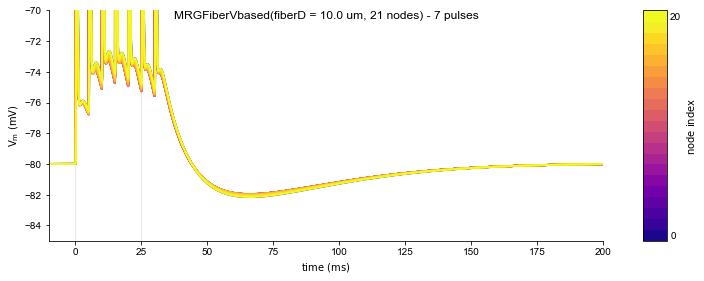

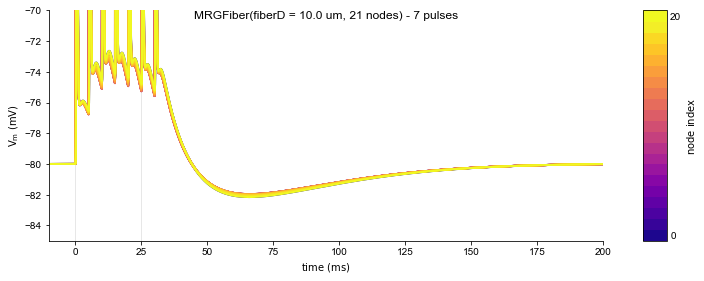

In [13]:
PW = 100e-6  # us
PRF = 200.0  # Hz
npulses = [1, 3, 7]
for n in npulses:
    tstim = n / PRF
    for cl, fiber in fiber_variants.items():
        fig = plotSimIClamp(fiber, PulsedProtocol(tstim, 200e-3 - tstim, PRF, PW * PRF), I=1.5e-9, ylim=(-85, -70), title=f'{fiber} - {n} pulse{"s" if n > 1 else ""}')

The model also exhibits an increase in the AHP amplitude and duration with an increase in the number of high-frequency (200 Hz) supra-threshold 100 us stimuli applied, identically as in the reference paper (fig 6).

### Comparison: conduction velocity (McIntyre 2002, fig 8A)

 18/06/2020 16:55:08: creating model with fiberD = 5.00 um ...
 18/06/2020 16:55:08: running fiberD parameter sweep (5.00 um - 20.00 um)
 18/06/2020 16:55:08: parameter sweep successfully completed
 18/06/2020 16:55:08: creating model with fiberD = 5.00 um ...
 18/06/2020 16:55:08: running fiberD parameter sweep (5.00 um - 20.00 um)
 18/06/2020 16:55:08: parameter sweep successfully completed


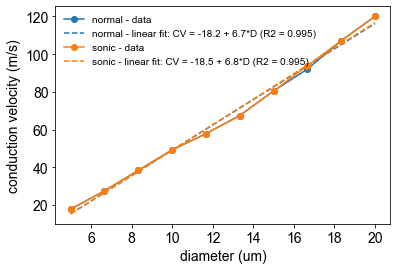

In [8]:
CV_dict = {}
for k, v in fiber_classes.items():
    CV_dict[k] = ConductionVelocityBatch(
        lambda x: v(x, nnodes),
        lambda x: IntracellularCurrent(x.central_ID),
        dense_diameters, pp, root=CV_root).run()
fig = plotCVvsDiameter(dense_diameters, CV_dict)

The action potential conduction velocity increases with the model's fiber diameter in a linear fashion ($R^2$ = 0.99). Notably, the computed values are slightly higher than those reported in the reference paper (fig 8A), however they stay within the same order of magnitude. 

### Comparison: SD curves for varying diameters

Iintra_thrs_vs_fiberD = {}
for D in sparse_diameters:
    for k, fiber_class in fiber_classes.items():
        fiber = fiber_class(D, nnodes)
        source = IntracellularCurrent(fiber.central_ID)
        Iintra_thrs_vs_fiberD[f'{D * 1e6:.1f}um - {k}'] = StrengthDurationBatch(SD_outkey, source, fiber, SD_durations, SD_offset, root=SD_root).run()
fig = strengthDurationCurve('SD curve - intracellular stimulation', SD_durations, Iintra_thrs_vs_fiberD, colors=paired_colors)

Expectedly, intracellular excitation thresholds are in the order of tenths to tens of nanoamperes, they increase with increasing fiber diameter, and decrease with increasing pulse until stabilization at a rheobase current for long enough stimuli. Moreover, characteristic chronaxies are in the order of hundreds of microseconds and seem to decrease with increasing fiber diameter. Finally, we can see that both model variants give us exactly the same results.

## Responses to extracellular stimulation

### Field distribution from point-source electrode in anisotropic medium

The extracellular potential field generated by a distant point-source electrode is solved here using an analytical solution to Poisson's equation considering an infinite homogeneous anisotropic medium with longitudinal resistivity $\rho_x = 300\ \Omega \cdot cm$ and transverse resistivity $\rho_z = 1200\ \Omega \cdot cm$, as in the reference paper.

For an electrode located at $(x_0, z_0)$ generating a current $I$, the extracellular potential value at a point $(x, z)$ is of the form:
$V_e(x, z) = \frac{I}{4 \pi \sqrt{\frac{(x - x_0)^2}{\rho_z^2} + \frac{(z - z_0)^2}{\rho_x \cdot \rho_z}}}$

Let's look at the extracellular voltage profile along a 10 um fiber generated by a point-source electrode located 100 um above the central node generating a 1 uA cathodic current. 

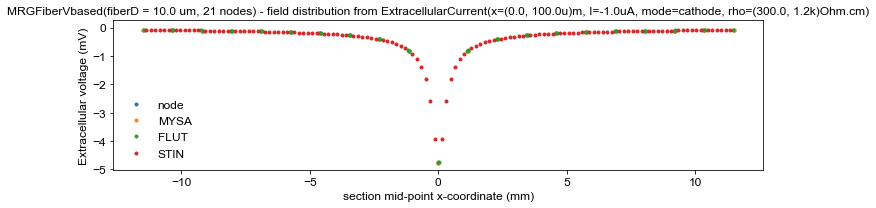

In [14]:
ext_source = ExtracellularCurrent((0., 100e-6), rho=rho_ext)
fig = plotFieldDistribution(fiber_variants['normal'], ext_source.updatedX(-1e-6))

Expectedly, the extracellular voltage is negative with a peak in absolute magnitude of around 5 mV around the central node.

### Model drive from the extracellular voltage distribution

There are two ways to implement the influence of the extracellular field on the model's electrical response:
1. Set the `e_extracellular` parameter of the extracellular mechanism associated to each section, for an explicit representation of the extracellular field as a set of voltage sources connected to the sections' extracellular side.
2. Compute an equivalent sets of intracellular currents corresponding to the longitudinal gradient of the extracellular electrical field along the fiber ($\Delta^2 V_e / \Delta x$) divided by the axoplasmic resistances between sections mid-points (as in the reference paper), for an indirect representation of the extracellular field assuming an infinitely long and straight axon.

### Comparison: typical supra-threshold response

We first aim to visualize the typical response of the model to a supra-threshold extracellular stimulus.

Here again, we verify that both model construction variants, as well as both approaches for the model drive from the extracellular field, produce identical responses to the same stimulus.

MRGFiberVbased(fiberD = 10.0 um, 21 nodes) simulation using explicit voltage sources


 18/06/2020 14:59:29: MRGFiberVbased(fiberD = 10.0 um, 21 nodes): simulation @ ExtracellularCurrent(x=(0.0, 100.0u)m, I=-2.1uA, mode=cathode, rho=(300.0, 1.2k)Ohm.cm), tstim = 100us, toffset = 3ms
 18/06/2020 14:59:29: MRGFiberVbased(fiberD = 10.0 um, 21 nodes): simulation @ ExtracellularCurrent(x=(0.0, 100.0u)m, I=-4.2uA, mode=cathode, rho=(300.0, 1.2k)Ohm.cm), tstim = 100us, toffset = 3ms
 18/06/2020 14:59:30: MRGFiberVbased(fiberD = 10.0 um, 21 nodes): simulation @ ExtracellularCurrent(x=(0.0, 100.0u)m, I=-8.4uA, mode=cathode, rho=(300.0, 1.2k)Ohm.cm), tstim = 100us, toffset = 3ms
 18/06/2020 14:59:31: MRGFiberVbased(fiberD = 10.0 um, 21 nodes): simulation @ ExtracellularCurrent(x=(0.0, 100.0u)m, I=-4.2uA, mode=cathode, rho=(300.0, 1.2k)Ohm.cm), tstim = 100us, toffset = 3ms
 18/06/2020 14:59:31: MRGFiberVbased(fiberD = 10.0 um, 21 nodes): simulation @ ExtracellularCurrent(x=(0.0, 100.0u)m, I=-6.3uA, mode=cathode, rho=(300.0, 1.2k)Ohm.cm), tstim = 100us, toffset = 3ms
 18/06/2020 14:

MRGFiberVbased(fiberD = 10.0 um, 21 nodes) simulation using equivalent injected currents


 18/06/2020 14:59:37: MRGFiberVbased(fiberD = 10.0 um, 21 nodes): simulation @ ExtracellularCurrent(x=(0.0, 100.0u)m, I=-2.1uA, mode=cathode, rho=(300.0, 1.2k)Ohm.cm), tstim = 100us, toffset = 3ms
 18/06/2020 14:59:38: MRGFiberVbased(fiberD = 10.0 um, 21 nodes): simulation @ ExtracellularCurrent(x=(0.0, 100.0u)m, I=-4.2uA, mode=cathode, rho=(300.0, 1.2k)Ohm.cm), tstim = 100us, toffset = 3ms
 18/06/2020 14:59:38: MRGFiberVbased(fiberD = 10.0 um, 21 nodes): simulation @ ExtracellularCurrent(x=(0.0, 100.0u)m, I=-8.4uA, mode=cathode, rho=(300.0, 1.2k)Ohm.cm), tstim = 100us, toffset = 3ms
 18/06/2020 14:59:39: MRGFiberVbased(fiberD = 10.0 um, 21 nodes): simulation @ ExtracellularCurrent(x=(0.0, 100.0u)m, I=-4.2uA, mode=cathode, rho=(300.0, 1.2k)Ohm.cm), tstim = 100us, toffset = 3ms
 18/06/2020 14:59:40: MRGFiberVbased(fiberD = 10.0 um, 21 nodes): simulation @ ExtracellularCurrent(x=(0.0, 100.0u)m, I=-6.3uA, mode=cathode, rho=(300.0, 1.2k)Ohm.cm), tstim = 100us, toffset = 3ms
 18/06/2020 14:

MRGFiber(fiberD = 10.0 um, 21 nodes) simulation using explicit voltage sources


 18/06/2020 14:59:45: MRGFiber(fiberD = 10.0 um, 21 nodes): simulation @ ExtracellularCurrent(x=(0.0, 100.0u)m, I=-2.1uA, mode=cathode, rho=(300.0, 1.2k)Ohm.cm), tstim = 100us, toffset = 3ms
 18/06/2020 14:59:47: MRGFiber(fiberD = 10.0 um, 21 nodes): simulation @ ExtracellularCurrent(x=(0.0, 100.0u)m, I=-4.2uA, mode=cathode, rho=(300.0, 1.2k)Ohm.cm), tstim = 100us, toffset = 3ms
 18/06/2020 14:59:48: MRGFiber(fiberD = 10.0 um, 21 nodes): simulation @ ExtracellularCurrent(x=(0.0, 100.0u)m, I=-8.4uA, mode=cathode, rho=(300.0, 1.2k)Ohm.cm), tstim = 100us, toffset = 3ms
 18/06/2020 14:59:50: MRGFiber(fiberD = 10.0 um, 21 nodes): simulation @ ExtracellularCurrent(x=(0.0, 100.0u)m, I=-4.2uA, mode=cathode, rho=(300.0, 1.2k)Ohm.cm), tstim = 100us, toffset = 3ms
 18/06/2020 14:59:52: MRGFiber(fiberD = 10.0 um, 21 nodes): simulation @ ExtracellularCurrent(x=(0.0, 100.0u)m, I=-6.3uA, mode=cathode, rho=(300.0, 1.2k)Ohm.cm), tstim = 100us, toffset = 3ms
 18/06/2020 14:59:54: MRGFiber(fiberD = 10.0 

MRGFiber(fiberD = 10.0 um, 21 nodes) simulation using equivalent injected currents


 18/06/2020 15:00:05: MRGFiber(fiberD = 10.0 um, 21 nodes): simulation @ ExtracellularCurrent(x=(0.0, 100.0u)m, I=-2.1uA, mode=cathode, rho=(300.0, 1.2k)Ohm.cm), tstim = 100us, toffset = 3ms
 18/06/2020 15:00:07: MRGFiber(fiberD = 10.0 um, 21 nodes): simulation @ ExtracellularCurrent(x=(0.0, 100.0u)m, I=-4.2uA, mode=cathode, rho=(300.0, 1.2k)Ohm.cm), tstim = 100us, toffset = 3ms
 18/06/2020 15:00:09: MRGFiber(fiberD = 10.0 um, 21 nodes): simulation @ ExtracellularCurrent(x=(0.0, 100.0u)m, I=-8.4uA, mode=cathode, rho=(300.0, 1.2k)Ohm.cm), tstim = 100us, toffset = 3ms
 18/06/2020 15:00:11: MRGFiber(fiberD = 10.0 um, 21 nodes): simulation @ ExtracellularCurrent(x=(0.0, 100.0u)m, I=-4.2uA, mode=cathode, rho=(300.0, 1.2k)Ohm.cm), tstim = 100us, toffset = 3ms
 18/06/2020 15:00:12: MRGFiber(fiberD = 10.0 um, 21 nodes): simulation @ ExtracellularCurrent(x=(0.0, 100.0u)m, I=-6.3uA, mode=cathode, rho=(300.0, 1.2k)Ohm.cm), tstim = 100us, toffset = 3ms
 18/06/2020 15:00:14: MRGFiber(fiberD = 10.0 

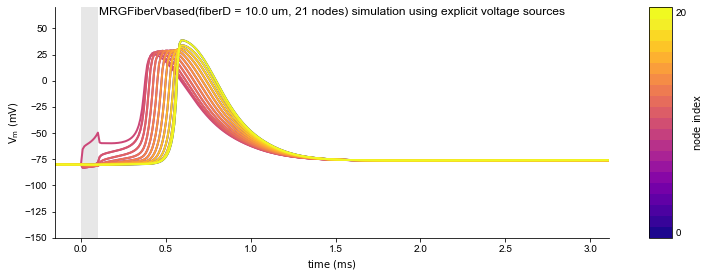

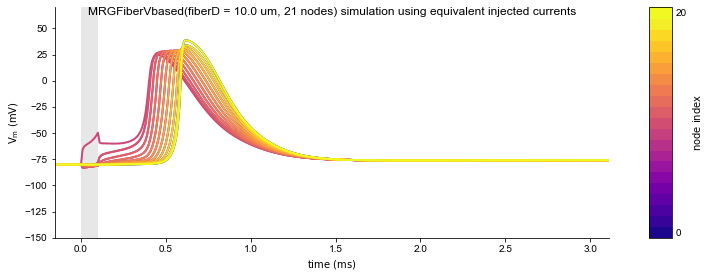

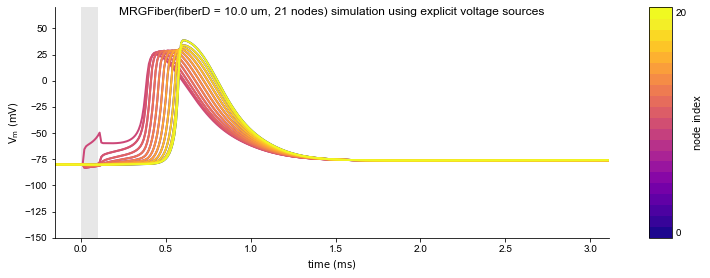

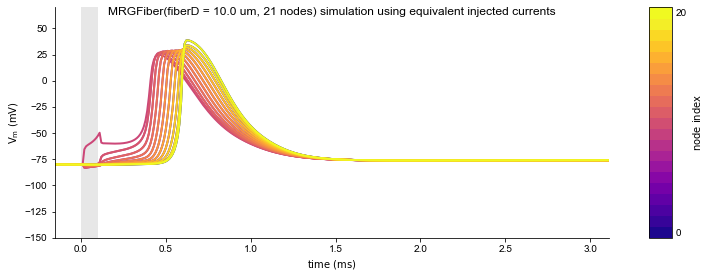

In [15]:
for k, fiber in fiber_variants.items():
    for cond in [False, True]:
        label = f'{fiber} simulation using {"equivalent injected currents" if cond else "explicit voltage sources"}'
        print(label)
        fiber.use_equivalent_currents = cond
        fig = plotSimExtSource(fiber, ext_source.updatedX(None), pp, title=label)

We obtain almost identical threshold excitation currents and identical distributed transmembrane voltage profiles, which confirms that both construction variants and stimulus drive representations produce equivalent electrical responses.

### Comparison: SD curves for varying diameters

 18/06/2020 15:00:27: Computing SD curve for MRGFiberVbased(fiberD = 5.0 um, 21 nodes) with ExtracellularCurrent(x=(0.0, 100.0u)m, mode=cathode, rho=(300.0, 1.2k)Ohm.cm)
 18/06/2020 15:00:27: Computing SD curve for MRGFiber(fiberD = 5.0 um, 21 nodes) with ExtracellularCurrent(x=(0.0, 100.0u)m, mode=cathode, rho=(300.0, 1.2k)Ohm.cm)
 18/06/2020 15:00:27: Computing SD curve for MRGFiberVbased(fiberD = 10.0 um, 21 nodes) with ExtracellularCurrent(x=(0.0, 100.0u)m, mode=cathode, rho=(300.0, 1.2k)Ohm.cm)
 18/06/2020 15:00:27: Computing SD curve for MRGFiber(fiberD = 10.0 um, 21 nodes) with ExtracellularCurrent(x=(0.0, 100.0u)m, mode=cathode, rho=(300.0, 1.2k)Ohm.cm)
 18/06/2020 15:00:27: Computing SD curve for MRGFiberVbased(fiberD = 20.0 um, 21 nodes) with ExtracellularCurrent(x=(0.0, 100.0u)m, mode=cathode, rho=(300.0, 1.2k)Ohm.cm)
 18/06/2020 15:00:27: Computing SD curve for MRGFiber(fiberD = 20.0 um, 21 nodes) with ExtracellularCurrent(x=(0.0, 100.0u)m, mode=cathode, rho=(300.0, 1.2k)Oh

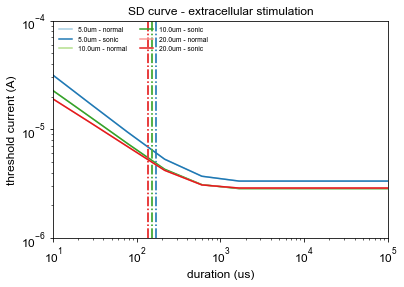

In [16]:
Iextra_thrs_vs_fiberD = {}
ext_source = ExtracellularCurrent((0., 100e-6), rho=rho_ext)
for D in sparse_diameters:
    for k, fiber_class in fiber_classes.items():
        fiber = fiber_class(D, nnodes)
        Iextra_thrs_vs_fiberD[f'{D * 1e6:.1f}um - {k}'] = StrengthDurationBatch(SD_outkey, ext_source, fiber, SD_durations, SD_offset, root=SD_root).run()
fig = strengthDurationCurve('SD curve - extracellular stimulation', SD_durations, Iextra_thrs_vs_fiberD, colors=paired_colors)

In this perfect scenario the electrode located just above a node, extracellular excitation thresholds are in the order of a few to tens of microamperes.

Expectedly, thresholds decrease slightly with increasing fiber diameter, and decrease with increasing pulse until stabilization at a rheobase current for long enough stimuli. Moreover, similarly as with intracellular stimulation, characteristic chronaxies are in the order of hundreds of microseconds and seem to decrease with increasing fiber diameter.

### SD curves for varying electrode locations (McIntyre 2002, fig 8B)

Let's evaluate the SD curve of a 10 um fiber for a combination of electrode-axon distances (200, 400 and 600 um) and longitudinal shifts w.r.t the central node (0, 0.25 and 0.5 times the internodal distance).

 18/06/2020 15:29:09: Computing SD curve for MRGFiberVbased(fiberD = 10.0 um, 21 nodes) with ExtracellularCurrent(x=(0.0, 200.0u)m, mode=cathode, rho=(300.0, 1.2k)Ohm.cm)
 18/06/2020 15:29:09: Computing SD curve for MRGFiberVbased(fiberD = 10.0 um, 21 nodes) with ExtracellularCurrent(x=(0.0, 400.0u)m, mode=cathode, rho=(300.0, 1.2k)Ohm.cm)
 18/06/2020 15:29:09: Computing SD curve for MRGFiberVbased(fiberD = 10.0 um, 21 nodes) with ExtracellularCurrent(x=(0.0, 600.0u)m, mode=cathode, rho=(300.0, 1.2k)Ohm.cm)
 18/06/2020 15:29:09: Computing SD curve for MRGFiberVbased(fiberD = 10.0 um, 21 nodes) with ExtracellularCurrent(x=(287.5u, 200.0u)m, mode=cathode, rho=(300.0, 1.2k)Ohm.cm)
 18/06/2020 15:29:09: Computing SD curve for MRGFiberVbased(fiberD = 10.0 um, 21 nodes) with ExtracellularCurrent(x=(287.5u, 400.0u)m, mode=cathode, rho=(300.0, 1.2k)Ohm.cm)
 18/06/2020 15:29:09: Computing SD curve for MRGFiberVbased(fiberD = 10.0 um, 21 nodes) with ExtracellularCurrent(x=(287.5u, 600.0u)m, mode

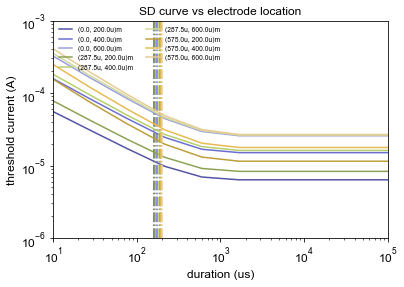

In [20]:
xrange = np.linspace(0., fiber_variants['normal'].interL / 2, 3)  # m
zrange = (np.arange(3) + 1) * 200e-6  # m
Iextra_thrs_vs_electrode_location = {}
for x in xrange:
    for z in zrange:
        ext_source = ExtracellularCurrent((x, z), rho=rho_ext)
        Iextra_thrs_vs_electrode_location[ext_source.strPos()] = StrengthDurationBatch(
            SD_outkey, ext_source, fiber_variants['normal'], SD_durations, SD_offset, root=SD_root).run()
fig = strengthDurationCurve('SD curve vs electrode location', SD_durations, Iextra_thrs_vs_electrode_location, colors=triad_colors)

We can see that across all conditions, thresholds are in the order of tens to hundreds of microamperes, and follow the expected trend as a function of pulse width. Moreover, the lowest thresholds are obtained for an electrode close to the axon and aligned with a Ranvier node. When the electrode is shifted away from this optimal location, thresholds can increase by up to 1 order of magnitude (!!!). 

#### Rheobase-normalized

Let's look at the SD curves normalized to their rheobase values, as in the reference paper.

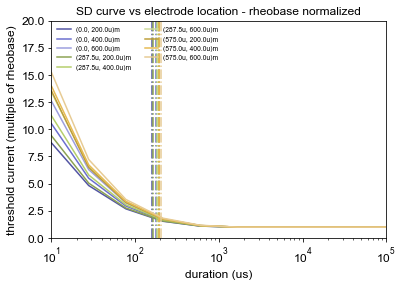

In [21]:
norm_Iextra_thrs_vs_electrode_location = {k: v / v[-1] for k, v in Iextra_thrs_vs_electrode_location.items()}
fig = strengthDurationCurve('SD curve vs electrode location - rheobase normalized', SD_durations, norm_Iextra_thrs_vs_electrode_location,
                            scale='log', yunit='multiple of rheobase', colors=triad_colors)
fig.axes[0].set_yscale('linear');
fig.axes[0].set_ylim(0., 20.);

We see that across all conditions, thresholds can increase by one order of magnitude compared to their rheobase value for very short pulse widths, similarly as in the reference paper (fig 8B). Moreover, it seems that this relative increase is amplified when the electrode location is optimized w.r.t. the fiber (close and aligned with a Ranvier node). 

 

### Threshold stimulus for varying electrode-axon distances (McIntyre 2002, fig 8C)

Let's evaluate the threshold excitation current from an extracellular electrode aligned with the central node using a 100 us pulse width, for three different fibers of characteristic diameters and for a range of electrode-axon distances (from 100 um to 1 mm)

 18/06/2020 15:59:55: Computing SD curve for MRGFiber(fiberD = 5.0 um, 21 nodes) with ExtracellularCurrent(x=(0.0, 0.0)m, mode=cathode, rho=(300.0, 1.2k)Ohm.cm)
 18/06/2020 15:59:56: Computing SD curve for MRGFiber(fiberD = 10.0 um, 21 nodes) with ExtracellularCurrent(x=(0.0, 0.0)m, mode=cathode, rho=(300.0, 1.2k)Ohm.cm)
 18/06/2020 15:59:56: Computing SD curve for MRGFiber(fiberD = 20.0 um, 21 nodes) with ExtracellularCurrent(x=(0.0, 0.0)m, mode=cathode, rho=(300.0, 1.2k)Ohm.cm)


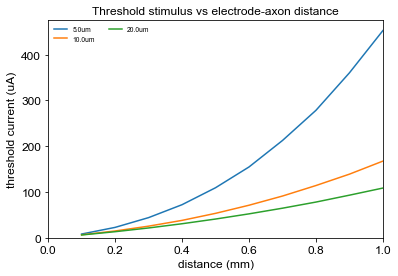

In [6]:
zrange_dense = np.linspace(100e-6, 1e-3, 10)  # m
Iextra_thrs_vs_electrode_distance = {}
ext_source = ExtracellularCurrent((0., 0.), rho=rho_ext)
for D in sparse_diameters:
    fiber = MRGFiber(D, nnodes)
    Iextra_thrs_vs_electrode_distance[f'{D * 1e6:.1f}um'] = StrengthDistanceBatch(SD_outkey, ext_source, fiber, pp, zrange_dense, root=SD_root).run()
fig = strengthDistanceCurve('Threshold stimulus vs electrode-axon distance', zrange_dense, Iextra_thrs_vs_electrode_distance, scale='lin', yfactor=1e6)

Expectedly, threshold currents increase both with increasing electrode-axon distance and with increasing fiber diameter. These results are quantitatively similar as those reported in the reference paper (fig 8C).

## Conclusions

We derived a user-friendly, readable and modular version of the MRG model, and showed that the model's responses to both intracellular and extracellular electrical stimuli are in very good agreement with the results reported in the original paper.

## References

McIntyre CC, Richardson AG, and Grill WM. *Modeling the excitability of mammalian nerve fibers: influence of afterpotentials on the recovery cycle.* Journal of Neurophysiology 87:995-1006, 2002.
